In [1]:
%matplotlib widget
from bmcs_shell.api import FETriangularMesh, TriXDomainFE, XDomainFE, FETS2D3U1M, MATS2DElastic, TriXDomainMITC, FETS2DMITC, MATSShellElastic
import numpy as np
from ibvpy.bcond import BCDof
from ibvpy.sim.tstep_bc import TStepBC
# from ibvpy.mats.viz3d_scalar_field import \
#     Vis3DStateField, Viz3DScalarField

## Benchmark example 1

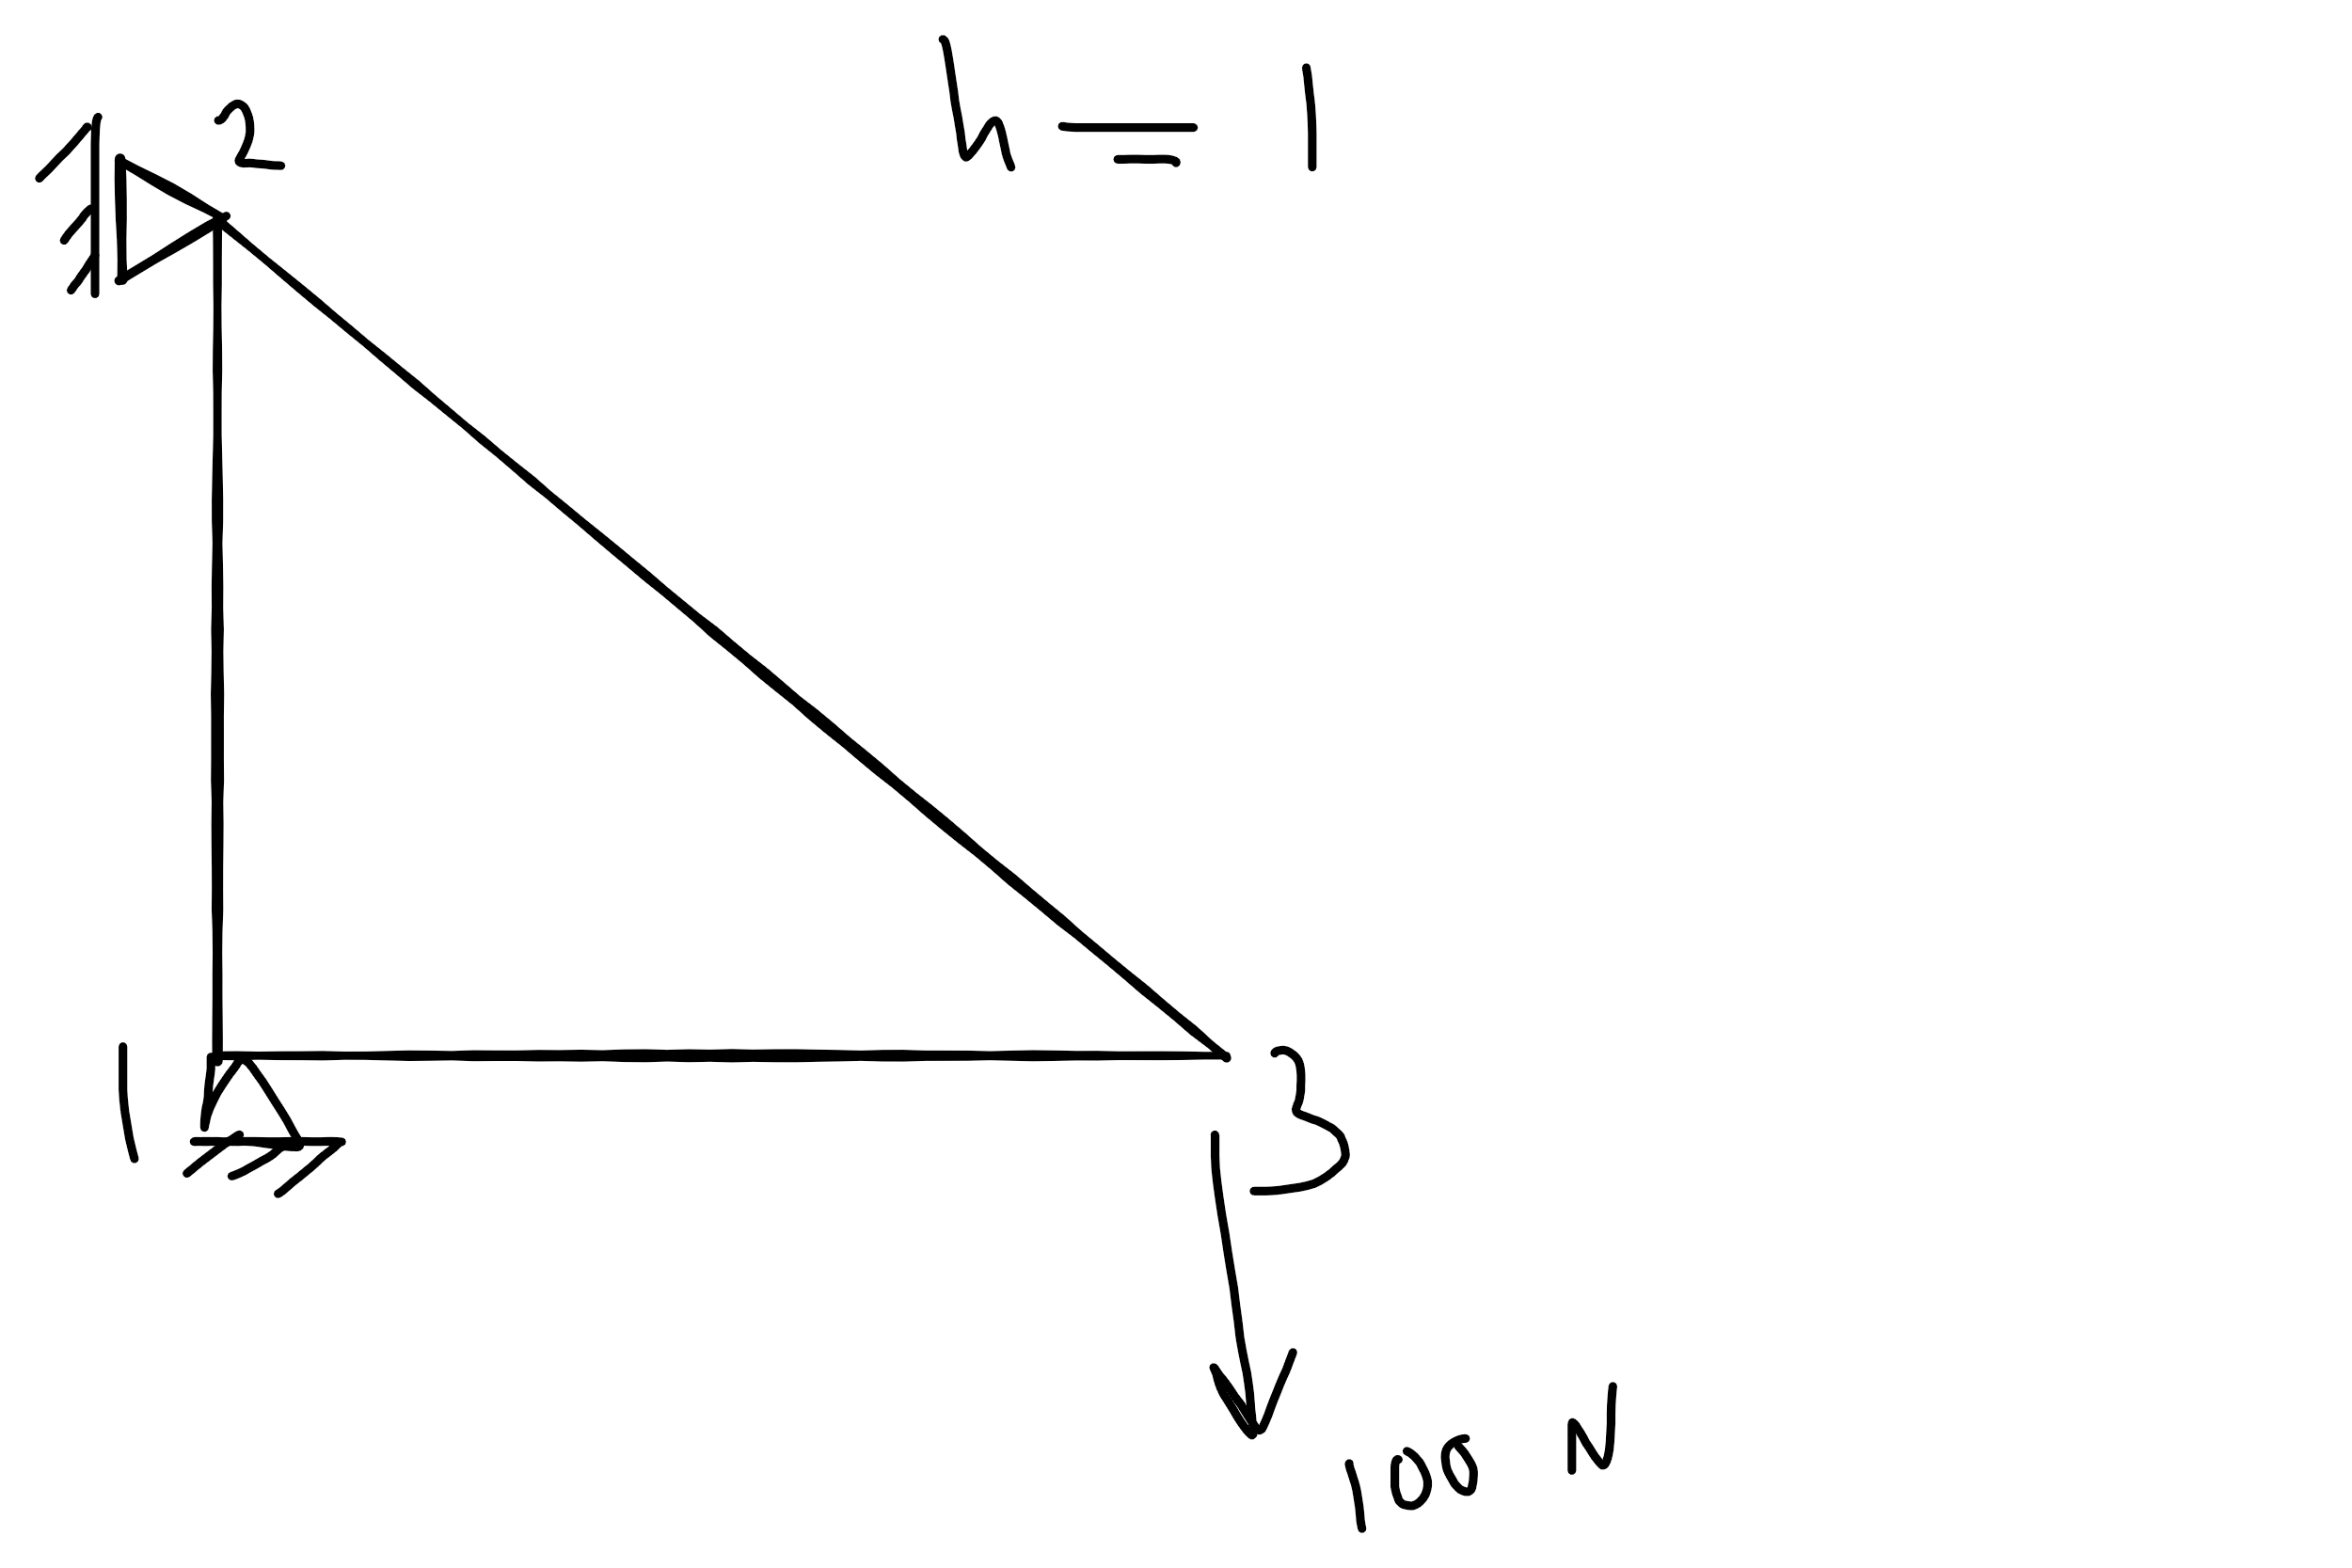

## Benchmark example 2

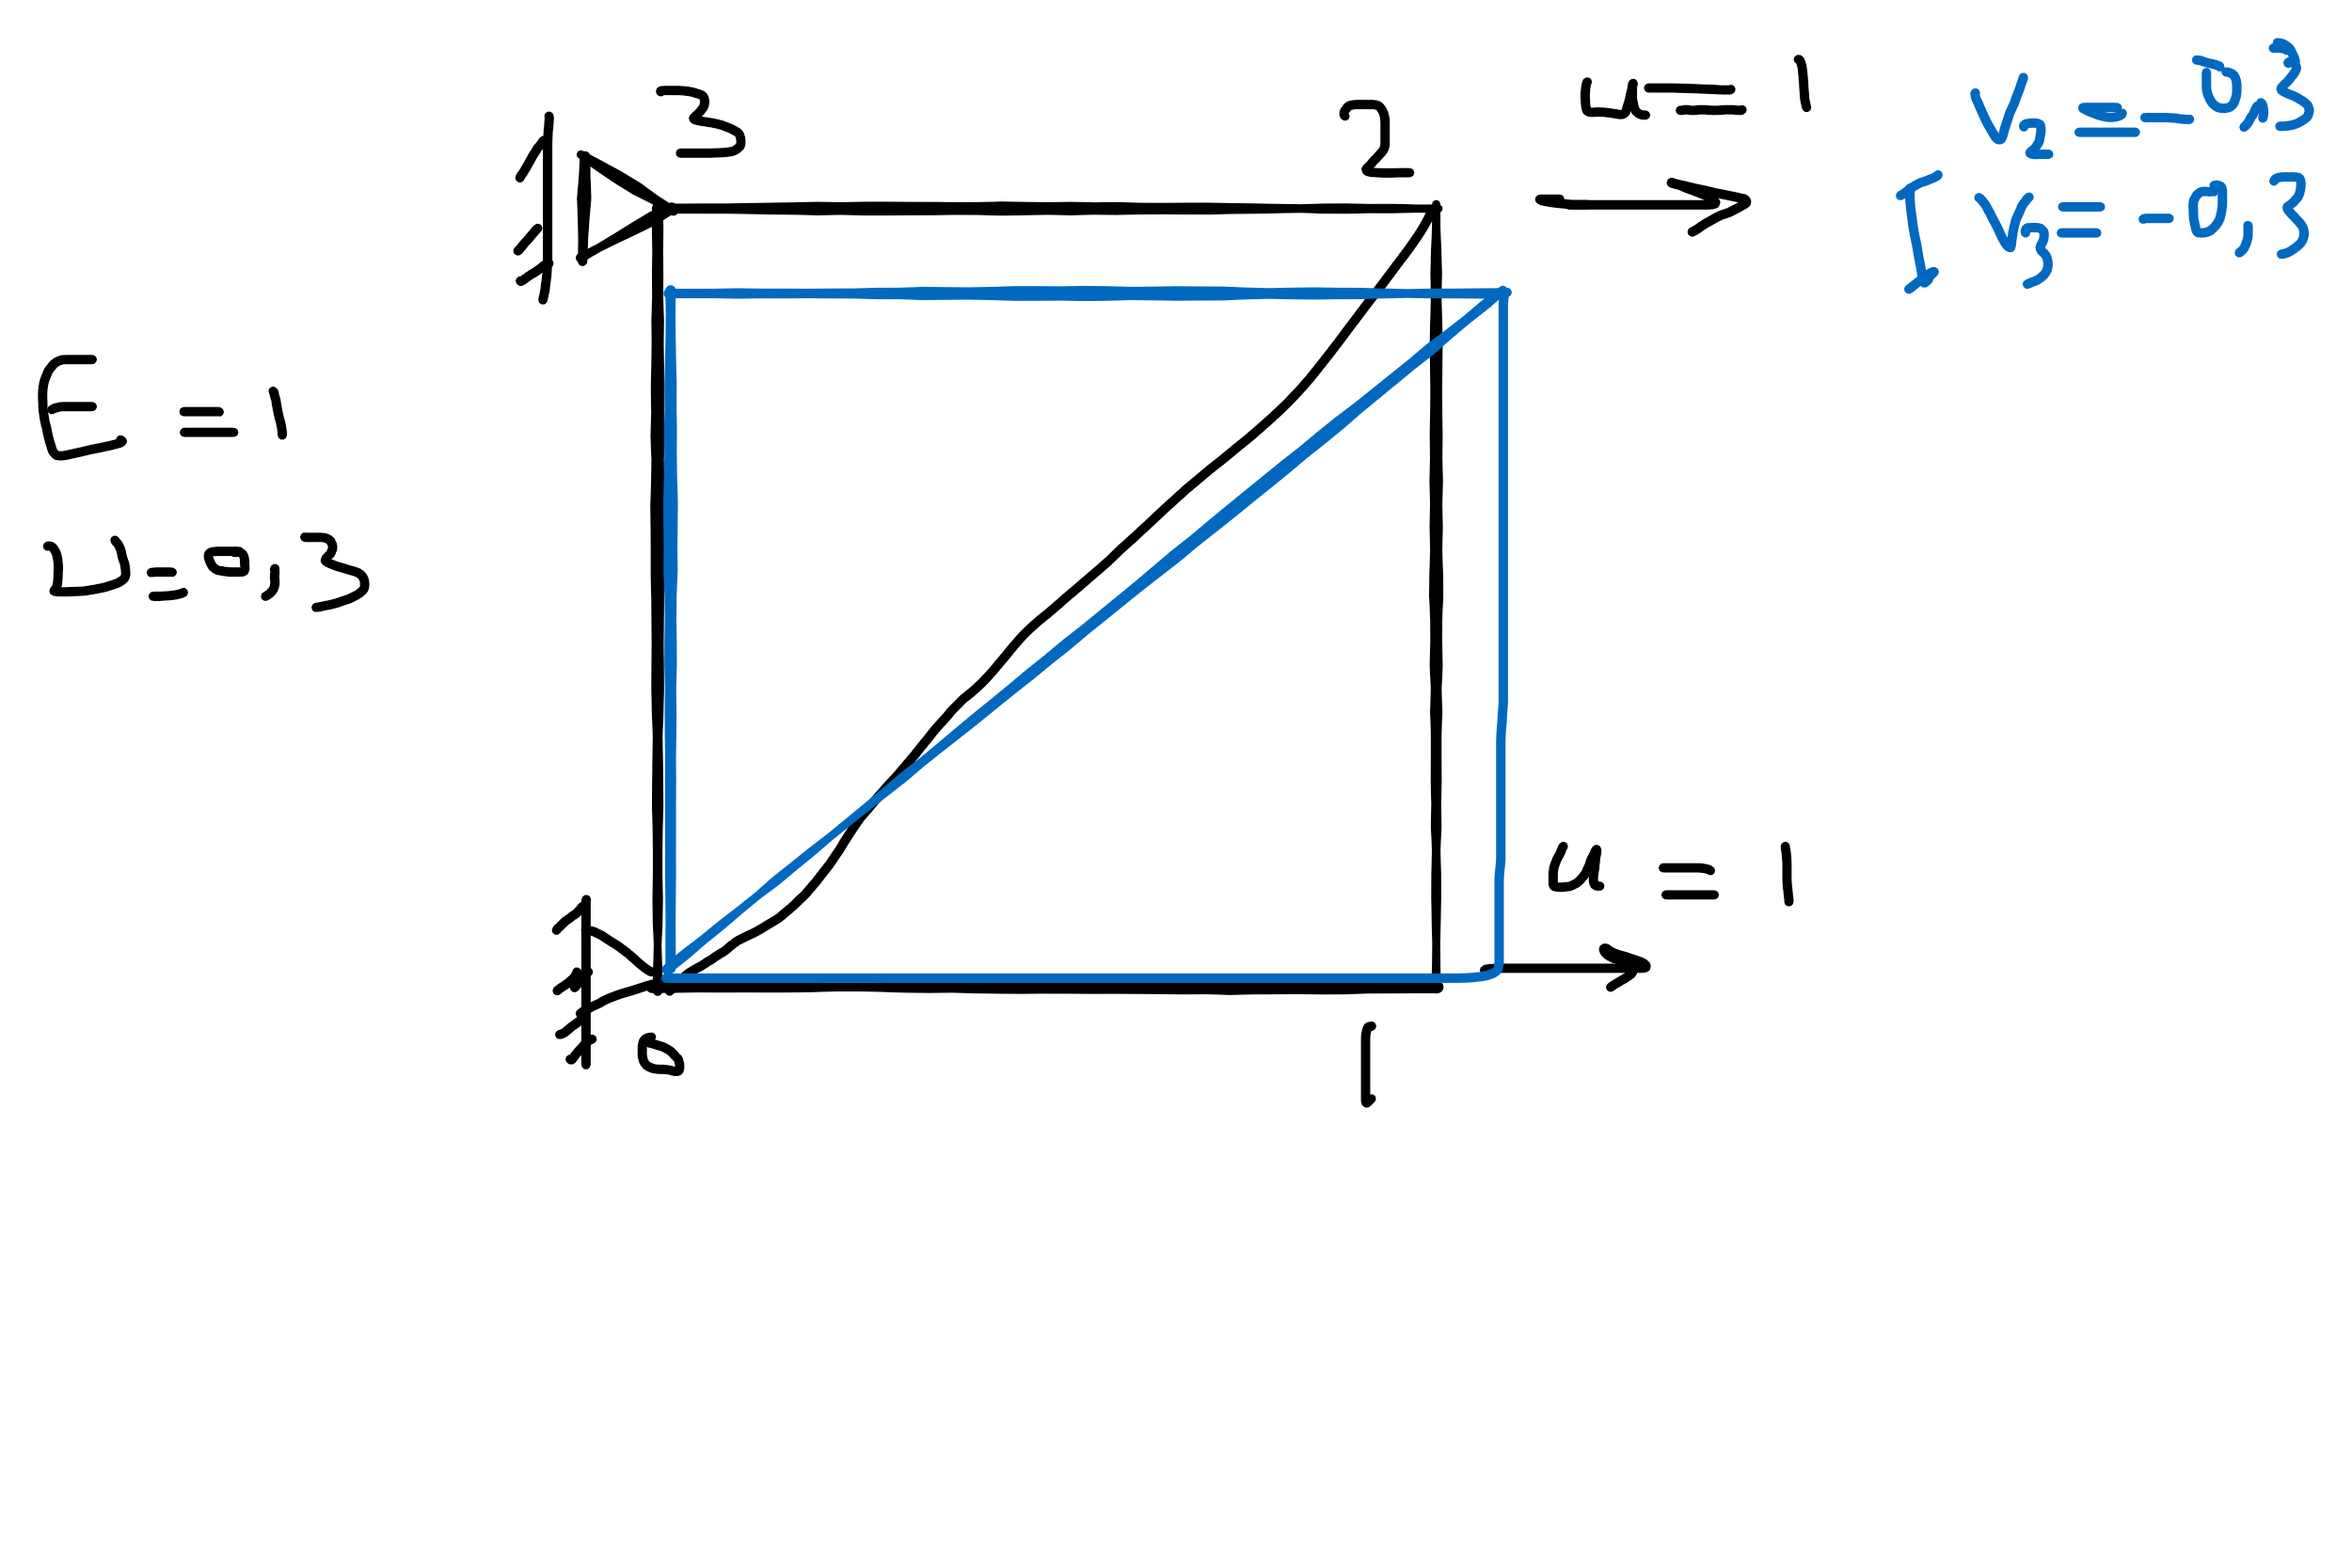

In [2]:
# Benchmark example 1
def run_sim(mitc = True):
    mesh = FETriangularMesh(
    X_Id=[[0,0,0], [0,100,0], [100,0,0]],
    I_Fi=[[0,1,2]] # this should be I_Ei when using XDomainFE later
    )
    if mitc:
        # shell element with 5 dofs (u_x, u_y, u_z, alpha, beta)
        fixed_dofs = [0, 1, 2, 3, 4,
                      5   , 7, 8, 9,
                            12, 13, 14]
        loaded_dofs = [11]
        mesh.fets = FETS2DMITC()
        xdomain = TriXDomainMITC(mesh=mesh)
        tmodel = MATSShellElastic(E=210000, nu=0.3)
    else:
        # plane element
        fixed_dofs = [0, 1, 2, 3, 5, 8]
        loaded_dofs = [7]
        xdomain = TriXDomainFE(mesh=mesh)
        tmodel = MATS2DElastic(E=210000, nu=0.3)

    u_cntl = -100
    bc_fixed = [BCDof(var= 'u', dof=dof, value=0) for dof in fixed_dofs]
    bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl) for dof in loaded_dofs]
    ts = TStepBC(
        domains=[(xdomain, tmodel)],
        bc=bc_fixed + bc_loaded,
    )
    s = ts.sim
    s.tloop.k_max = 10
    s.tline.step = 1
    s.tloop.verbose = True
    s.run()
    print('F_t')
    print(ts.hist.F_t)
    print('U_t')
    print(ts.hist.U_t)
    return xdomain

In [24]:
# Benchmark example 1 with additional element in z direction 
def run_sim(mitc = True):
    mesh = FETriangularMesh(
    X_Id=[[0,0,0], [0,100,0], [100,0,0], [0,100,100]],
    I_Fi=[[0,1,2], [0,2,3]] # this should be I_Ei when using XDomainFE later
    )
    if mitc:
        # shell element with 5 dofs (u_x, u_y, u_z, alpha, beta)
        fixed_dofs = [0, 1, 2, 3, 4,
                      5   , 7, 8, 9,
                            12, 13, 14,
                        18, 19]
        loaded_dofs = [11, 16]
        mesh.fets = FETS2DMITC()
        xdomain = TriXDomainMITC(mesh=mesh)
        tmodel = MATSShellElastic(E=210000, nu=0.3)
    else:
        # plane element
        fixed_dofs = [0, 1, 2, 3, 5, 8]
        loaded_dofs = [7]
        xdomain = TriXDomainFE(mesh=mesh)
        tmodel = MATS2DElastic(E=210000, nu=0.3)

    u_cntl = -100
    bc_fixed = [BCDof(var= 'u', dof=dof, value=0) for dof in fixed_dofs]
    bc_loaded = [BCDof(var= 'f', dof=dof, value=u_cntl) for dof in loaded_dofs]
    ts = TStepBC(
        domains=[(xdomain, tmodel)],
        bc=bc_fixed + bc_loaded,
    )
    s = ts.sim
    s.tloop.k_max = 10
    s.tline.step = 1
    s.tloop.verbose = True
    s.run()
    print('F_t')
    print(ts.hist.F_t)
    print('U_t')
    print(ts.hist.U_t)
    return xdomain

In [2]:
# Benchmark example 2 (Patch test)
def run_sim(mitc = True):
    mesh = FETriangularMesh(
    X_Id=[[0,0,0], [100,0,0], [100,100,0], [0,100,0]],
    I_Fi=[[0,1,2], [0,2,3]] # this should be I_Ei when using XDomainFE later
    )
    if mitc:
        # shell element with 5 dofs (u_x, u_y, u_z, alpha, beta)
        fixed_dofs = [0, 1, 2, 3, 4,
                            7, 8, 9,
                            12, 13, 14,
                     15   , 17, 18, 19]
        loaded_dofs = [5, 10]
        mesh.fets = FETS2DMITC()
        xdomain = TriXDomainMITC(mesh=mesh)
        tmodel = MATSShellElastic(E=1, nu=0.3)
    else:
        # plane element
        fixed_dofs = [0, 1, 2, 
                            5,
                            8,
                      9   , 11]
        loaded_dofs = [3, 6]
        xdomain = TriXDomainFE(mesh=mesh)
        tmodel = MATS2DElastic(E=1, nu=0.3)

    u_cntl = 1
    bc_fixed = [BCDof(var= 'u', dof=dof, value=0) for dof in fixed_dofs]
    bc_loaded = [BCDof(var= 'u', dof=dof, value=u_cntl) for dof in loaded_dofs]
    ts = TStepBC(
        domains=[(xdomain, tmodel)],
        bc=bc_fixed + bc_loaded,
    )
    s = ts.sim
    s.tloop.k_max = 10
    s.tline.step = 1
    s.tloop.verbose = True
    s.run()
    print('F_t')
    print(ts.hist.F_t)
    print('U_t')
    print(ts.hist.U_t)
    return xdomain

## Old plane element

In [16]:
xdomain = run_sim(mitc = False)

t:	 0.00
U_o, [0. 0. 0. 0. 0. 0. 0. 0. 0.]
eps_Eso, [[0. 0. 0.]]
map_field_to_K:
K_Eij: [[[ 115384.61538462       0.               0.               0.
     34615.38461538       0.         -115384.61538462  -34615.38461538
         0.        ]
  [      0.           40384.61538462       0.           40384.61538462
         0.               0.          -40384.61538462  -40384.61538462
         0.        ]
  [      0.               0.               0.               0.
         0.               0.               0.               0.
         0.        ]
  [      0.           40384.61538462       0.           40384.61538462
         0.               0.          -40384.61538462  -40384.61538462
         0.        ]
  [  34615.38461538       0.               0.               0.
    115384.61538462       0.          -34615.38461538 -115384.61538462
         0.        ]
  [      0.               0.               0.               0.
         0.               0.               0.               0.
   

In [7]:
# Test strains
U_o = np.array([0, 0, 0,
                0, 1, 0,
                0, 0, 0], dtype=np.float_)
eps_Emab = xdomain.map_U_to_field(U_o)
eps_Emab


U_o, [0. 0. 0. 0. 1. 0. 0. 0. 0.]
eps_Eso, [[ 0.005  0.005 -0.01 ]]


array([[ 0.005,  0.005, -0.01 ]])

## Using shell element

In [3]:
xdomain = run_sim(mitc = True)

t:	 0.00U_o: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
U_Eio, [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
(0), 
	 1.00U_o: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
U_Eio, [[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]
U_o: [ 0.          0.          0.          0.          0.          0.
  0.02114286  0.          0.          0.         -0.00190476  0.02171429
  0.          0.          0.        ]
U_Eio, [[[-0.00190476  0.02171429  0.          0.          0.        ]
  [ 0.          0.02114286  0.          0.          0.        ]
  [ 0.          0.          0.          0.          0.        ]]]
(1), 

F_t
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.00000000e+02  1.00000000e+02  0.00000000e+00 -1.66666672e+01
  -1.66666672e+01  1.00000000e+02 -4

In [4]:
# Test strains
U_o = np.array([0, 0, 0, 0, 0,
                0, 1, 0, 0, 0,
                0, 0, 0, 0, 0], dtype=np.float_)
eps_Emab = xdomain.map_U_to_field(U_o)
eps_Emab

U_o: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
U_Eio, [[[0. 0. 0. 0. 0.]
  [0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]]


array([[[0.  , 0.01, 0.  , 0.  , 0.  ]]])

# Matrices derivation

## Calculating B matrix

The displacement approximation is constructed using in-plane shape functions and the transversal vector given by the rotations $\alpha$ and $\beta$ around the orthogonal in-plane vectors $v_{a1}$ and $v_{a2}$.  

$$
 u_a(\eta,\xi,\zeta) = N_i(\eta, \xi) \left( u_{ia} + \frac{1}{2} \zeta t_i
 \left(v_{ia1} \alpha_i - v_{ia2} \beta_i \right) \right)
$$

The goal is to transform the nodal values $u_{ia}$ and $\alpha_i$ and $\beta_i$ into a nodal vector with five values.

$$
\mathcal{V}_{iar} = [v_{ia1}, -v_{ia2} ] \\
\Phi_{ir} = [\alpha_i, \beta_i]
$$

$$
 u_a(\eta, \xi, \zeta) = 
 N_i(\eta, \xi) \, u_{ia} + N_i(\eta, \xi) \, 
 \frac{1}{2} \zeta t_i \mathcal{V}_{iar} \Phi_{ir}
$$

The nodal five parameter vector $\mathcal{U}_o$ with the $o$ denoting the three displacements $a$ and two rotations $r$ within a node is introduced using the two mappings

$$
 u_{a} = \delta_{ao} \mathcal{U}_o \\
 \Phi_{r} = \delta_{ro} \mathcal{U}_o
$$
where $\delta_{oi}$ and $\delta_{or}$ are the placement operators defined as
$$
 \delta_{ao} = 
 \left[
 \begin{array}{ccccc}
   1 & 0 & 0 & 0 & 0 \\
   0 & 1 & 0 & 0 & 0 \\
   0 & 0 & 1 & 0 & 0
 \end{array}
 \right]
$$
and 
$$
\delta_{ro} = 
\left[
\begin{array}{ccccc}
0 & 0 & 0 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{array}
\right]
$$

Then, the displacement approximation can be rewritten to

$$
 u_a(\eta, \xi, \zeta) = 
 N_i(\eta, \xi) \, \delta_{ao } \mathcal{U}_{io} + N_i(\eta, \xi) \, 
 \frac{1}{2} \zeta \mathcal{V}_{iar} \delta_{ro} \mathcal{U}_{io}
$$

so that, finally a decomposed mapping operator is found for all nodal parameters in the following form

$$
 u_a(\eta, \xi, \zeta)
 = 
 \left(
 N_i \delta_{ao} + N_i \frac{1}{2} t_i \zeta \mathcal{V}_{iar} \delta_{ro} \right)
 \mathcal{U}_{io}
$$

From this place, the derivation of strains and of the kinematic matrix $B$ follows the same lines as in the continuum.

**Here's a renaming for curvilinear coordinates and indices that is comptaible with Bathe papers and the implementation in the code**

$$
 u_a(r, s, t)
 = 
 \left(
 N_i \delta_{ao} + (N t)_i \frac{1}{2} a_i \mathcal{V}_{iav} \delta_{vo} \right)
 \mathcal{U}_{io}
$$

\begin{align}
\varepsilon_{ab} &= \frac{1}{2}
\left(\frac{\partial u_a}{\partial x_b} +
 \frac{\partial u_b}{\partial x_a}\right) \\
&= \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \frac{\partial u_c}{\partial x_d}
\\
&=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
 \left( \frac{\partial N_i}{\partial x_d} \delta_{co} + \frac{\partial (Nt)_i}{\partial x_d} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\left( \frac{\partial N_i}{\partial r_r}\frac{\partial r_r}{\partial x_d} \delta_{co} + \frac{\partial (Nt)_i}{\partial r_r}\frac{\partial r_r}{\partial x_d} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) \mathcal{U}_{io}
\\
 &=
 \frac{1}{2}
\left( \delta_{ac} \delta_{bd} + \delta_{ad} \delta_{bc}\right)
\left( \frac{\partial N_i}{\partial r_r} \delta_{co} + \frac{\partial (Nt)_i}{\partial r_r} \frac{1}{2} a_i \mathcal{V}_{icv} \delta_{vo} \right) (J^{-1})_{rd} \mathcal{U}_{io}
\end{align}

$\mathcal{U}_{io}$: the known nodal displacements for one element ($i$=num_of_nodes=3, $o$=dofs=5)

$\varepsilon_{ab}$: the evaluated strain at one Gauss point with coords $(r, s, t)$

$N(r, s, t)$

In [5]:
Vn_Fid, v1_Fid, v2_Fid = xdomain.v_vectors

In [6]:
delta25_vo = np.zeros((2, 5), dtype='f')
delta25_vo[(0, 1), (3, 4)] = 1
delta25_vo

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [7]:
delta35_co = np.zeros((3, 5), dtype='f')
delta35_co[(0, 1, 2), (0, 1, 2)] = 1
delta35_co

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [8]:
V_Ficv = np.zeros((*v2_Fid.shape, 2), dtype='f')
V_Ficv[..., 0] = v1_Fid
V_Ficv[..., 1] = v2_Fid

In [9]:
a = xdomain.fets.a
dN_imr = xdomain.fets.dh_imr
dNt_imr = xdomain.fets.dht_imr

delta = np.identity(3)
Diff1_abcd = 0.5 * (
    np.einsum('ac,bd->abcd', delta, delta) +
    np.einsum('ad,bc->abcd', delta, delta)
)

J_Fmrd = xdomain.dx_dr_Fmrd

inv_J_Fmrd = np.linalg.inv(J_Fmrd)
det_J_Fm = np.linalg.det(J_Fmrd)
B1_Emiabo = np.einsum('abcd, imr, co, Emrd -> Emiabo', Diff1_abcd, dN_imr, delta35_co, inv_J_Fmrd)
B2_Emiabo = np.einsum('abcd, imr, Ficv, vo, Emrd -> Emiabo', Diff1_abcd, dNt_imr, 0.5*a*V_Ficv, delta25_vo, inv_J_Fmrd)

B_Emiabo = B1_Emiabo + B2_Emiabo
B_Emiabo

array([[[[0.   , 0.   , 0.005],
         [0.   , 0.   , 0.   ],
         [0.005, 0.   , 0.   ]]]])

### Test strains

In [14]:
U_io = np.array([[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 1, 0, 0]], dtype=np.float_)
eps_Emab = np.einsum('Emiabo, io -> Emab', B_Emiabo, U_io)
eps_Emab

array([[[[0.   , 0.   , 0.005],
         [0.   , 0.   , 0.   ],
         [0.005, 0.   , 0.   ]]]])

## Calculating stiffness matrix k

In [13]:
w_m = xdomain.fets.w_m # Gauss points weights
B_Emiabo, det_J_Fm = xdomain.B_Emiabo
E_ = 1000
nu_ = 0.3
k = 5/6
D_Est = E_ / (1 - nu_ ** 2) * np.array([[[1, nu_, 0, 0, 0],
                                        [nu_, 1, 0, 0, 0],
                                        [0, 0, 0.5 * (1 - nu_),     0, 0],
                                        [0, 0, 0, 0.5 * (1 - nu_) * k, 0],
                                        [0, 0, 0, 0, 0.5 * (1 - nu_) * k]]])

# Mapping ab to p (3x3 -> 5)
B_Emipo = B_Emiabo[:, :, :, (0, 1, 0, 1, 0), (0, 1, 1, 2, 2), :]

E, m, i, p, o = B_Emipo.shape
B_Empio = np.einsum('Emipo->Empio', B_Emipo)
B_Empf = B_Empio.reshape((E, m, p, 3 * o))

k2_Emop = xdomain.integ_factor * np.einsum('m, Empf, Ept, Emtq, Em -> Emfq', w_m, B_Empf, D_Est, B_Empf,
                                           det_J_Fm)

k2_Eop = np.sum(k2_Emop, axis=1)
k2_Eop

# o_Ei = xdomain.o_Eia.reshape(-1, 3 * 5)
# o_Ei
# SysMtxArray(mtx_arr=k2_Eop, dof_map_arr=o_Ei)

array([[[-2.98763736e+02, -1.06456044e+02,  0.00000000e+00,
          1.77426745e+01, -4.97939575e+01,  2.40384615e+01,
          8.24175824e+01,  0.00000000e+00, -1.37362641e+01,
          4.00641038e+00,  2.74725275e+02,  2.40384615e+01,
          0.00000000e+00, -4.00641038e+00,  4.57875472e+01],
        [-1.06456044e+02, -2.98763736e+02,  0.00000000e+00,
          4.97939575e+01, -1.77426745e+01,  2.40384615e+01,
          2.74725275e+02,  0.00000000e+00, -4.57875472e+01,
          4.00641038e+00,  8.24175824e+01,  2.40384615e+01,
          0.00000000e+00, -4.00641038e+00,  1.37362641e+01],
        [ 0.00000000e+00,  0.00000000e+00, -4.00641026e+01,
         -6.67735003e+02,  6.67735003e+02,  0.00000000e+00,
          0.00000000e+00,  2.00320513e+01, -6.67735063e+02,
          6.67735063e+02,  0.00000000e+00,  0.00000000e+00,
          2.00320513e+01, -6.67735063e+02,  6.67735063e+02],
        [ 1.77426745e+01,  4.97939575e+01, -6.67735003e+02,
         -2.22661311e+04,  2.95711251

## Force

In [16]:
sig_Ems = np.array([[[0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0],
                   [0, 0, 0, 0, 0]]])

In [17]:
B_Emiabo, det_J_Fm = xdomain.B_Emiabo

B_Empf = xdomain._get_B_Empf()
f_Emf = xdomain.integ_factor * np.einsum('m, Emsf, Ems, Em -> Emf', xdomain.fets.w_m, B_Empf, sig_Ems, det_J_Fm)
f_Ef = np.sum(f_Emf, axis=1)

o_Ei = xdomain.o_Eia.reshape(-1, 3 * 5)

o_Ei.flatten(), f_Ef.flatten()

(array([10, 11, 12, 13, 14,  5,  6,  7,  8,  9,  0,  1,  2,  3,  4]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

## 2. Solving plane element manually

In [2]:
h = 1

x1 = 0
y1 = 0
x2 = 0
y2 = 100
x3 = 100
y3 = 0

E = 210000
nu = 0.3
A = 100*100/2
C = E / (1 - nu ** 2) * np.array([[1, nu, 0], [nu, 1, 0], [0, 0, 0.5 * (1 - nu)]])
B = (1/(2*A)) * np.array([
    [y2-y3, 0, y3-y1, 0, y1-y2, 0],
    [0, x3-x2, 0, x1-x3, 0, x2-x1],
    [x3-x2, y2-y3, x1-x3, y3-y1, x2-x1, y1-y2]
])
B

array([[ 0.01,  0.  ,  0.  ,  0.  , -0.01,  0.  ],
       [ 0.  ,  0.01,  0.  , -0.01,  0.  ,  0.  ],
       [ 0.01,  0.01, -0.01,  0.  ,  0.  , -0.01]])

In [3]:
k = A*h*np.dot(B.T, C)
k = np.dot(k, B)
k

array([[ 155769.23076923,   75000.        ,  -40384.61538462,
         -34615.38461538, -115384.61538462,  -40384.61538462],
       [  75000.        ,  155769.23076923,  -40384.61538462,
        -115384.61538462,  -34615.38461538,  -40384.61538462],
       [ -40384.61538462,  -40384.61538462,   40384.61538462,
              0.        ,       0.        ,   40384.61538462],
       [ -34615.38461538, -115384.61538462,       0.        ,
         115384.61538462,   34615.38461538,       0.        ],
       [-115384.61538462,  -34615.38461538,       0.        ,
          34615.38461538,  115384.61538462,       0.        ],
       [ -40384.61538462,  -40384.61538462,   40384.61538462,
              0.        ,       0.        ,   40384.61538462]])

In [4]:
k_dof = k[3:,3:]
k_dof

array([[115384.61538462,  34615.38461538,      0.        ],
       [ 34615.38461538, 115384.61538462,      0.        ],
       [     0.        ,      0.        ,  40384.61538462]])

In [5]:
k_inv = np.linalg.inv(k_dof)
k_inv

array([[ 9.52380952e-06, -2.85714286e-06,  0.00000000e+00],
       [-2.85714286e-06,  9.52380952e-06,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  2.47619048e-05]])

In [6]:
f = np.array([0, 0, -100])
u = np.dot(k_inv, f)
u

array([ 0.        ,  0.        , -0.00247619])

## 3. Solving plane element using ibvpy

In [8]:
xdomain.T_Fab

array([[[-0.70710678,  0.70710678,  0.        ],
        [-0.70710678, -0.70710678, -0.        ],
        [ 0.        ,  0.        ,  1.        ]]])

In [9]:
xdomain.x_Eia

array([[[  0.        ,   0.        ],
        [141.42135624,   0.        ],
        [ 70.71067812,  70.71067812]]])

In [10]:
xdomain.J_Emar

array([[[[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.71067812,   0.        ],
         [  0.        ,  70.71067812,   0.        ]],

        [[141.42135624,  70.

In [ ]:
F_to = ts.hist.F_t
U_to = ts.hist.U_t
F_loaded = np.sum(F_to[:, loaded_dofs], axis=-1)
F_fixed = np.sum(F_to[:, fixed_dofs], axis=-1)
U_loaded = np.average(U_to[:, loaded_dofs], axis=-1)
F_loaded
U_to[-1]

In [ ]:
U1 = ts.hist.U_t[-1]
print(U1)
eps1 = ts.fe_domain[0].xdomain.map_U_to_field(U1)
sig1, _ = ts.fe_domain[0].tmodel.get_corr_pred(eps1,1)
sig_x, sig_y, tau = sig1.T
sig_ab = np.einsum('ab...->...ab', np.array([[sig_x, tau], [tau, sig_y]], dtype=np.float))
sig_val, sig_dir = np.linalg.eig(sig_ab)
[np.min(sig_val), np.max(sig_val)]

In [ ]:
Diff1_abcd

$$
J_{ar} =  \frac{\partial N_i}{\partial \eta_r} 
x_{ia}
$$
this can be transformed 
$$
J_{Emar} = \left. \frac{\partial N_i}{\partial \eta_r} \right|_m
x_{Eia}
$$
Zienkiewicz

In [18]:
x_Ia = xdomain.X_Id[..., :-1]
x_Eia = x_Ia[xdomain.I_Ei]
delta = np.identity(2) 
Diff1_abcd = 0.5 * (
        np.einsum('ac,bd->abcd', delta, delta) +
        np.einsum('ad,bc->abcd', delta, delta)
)
dN_mir = np.array([[[1, 0], [0, 1], [-1, -1]]], dtype=np.float_)
J_Emar = np.einsum('mir, Eia -> Emar', dN_mir, x_Eia)
inv_J_Emra = np.linalg.inv(J_Emar)
det_J_Emra = np.linalg.det(J_Emar)
B_Eimabc = np.einsum('abcd, mir, Emrd -> Eimabc', Diff1_abcd, dN_mir, inv_J_Emra)
U_Eic = np.array([[[0, 0], [1, 0], [0, 1]]], dtype=np.float_)
eps_Emab = np.einsum('Eimabc,Eic->Emab', B_Eimabc, U_Eic)
eps_Emab

array([[[[ 0.  ,  0.  ],
         [ 0.  , -0.01]]]])

In [23]:
eps2_Emab = np.einsum('Eimabc,Eic->Emab', xdomain.B1_Eimabc, U_Eic)
eps2_Emab

array([[[[ 0.00707107, -0.00353553],
         [-0.00353553,  0.01414214]]]])